This notebook briefly outlines how to get lightcurve data for particular events from different microlensing alert webpages.

# MOA

# OGLE

# KMTNet

In [38]:
import requests
import pandas as pd
from io import BytesIO

# Figure out a way to skip the first line.
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/data/KB220001/pysis/KMTA01_I.pysis"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), delim_whitespace=True, skiprows=1, header=None)

In [39]:
type(df[0][0])

numpy.float64

In [40]:
# Why is there missing data???
url = "http://www.massey.ac.nz/~iabond/moa/alert2022/fetchtxt.php?path=moa/ephot/phot-gb8-R-3-40286.dat"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), delim_whitespace=True, skiprows=11, skipfooter=1, header=None, engine='python')

In [41]:
type(df[0][0])

numpy.float64

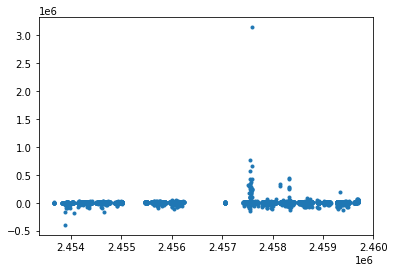

In [48]:
import matplotlib.pyplot as plt
plt.plot(df.iloc[:,0], df.iloc[:,1], '.')